In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install pyphysim
clear_output()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from pyphysim.util.misc import randn_c
from pyphysim.modulators.fundamental import BPSK, QAM, Modulator

## Data

In [ ]:
def generate_sample(n_symbols=4, n_symbol_array=8):
    samples = []
    for array in range(n_symbols ** n_symbol_array):
        sample = np.zeros(n_symbol_array)
        for counter in range(n_symbol_array):
            sample[counter] = array % n_symbols
            array = array // n_symbols
            
        samples.append(sample)   
    
    samples = np.stack(samples).astype(np.int32)
    modulator = BPSK() if n_symbols == 2 else QAM(n_symbols)
    sym_samples = modulator.modulate(samples)
    return sym_samples

In [ ]:
def mu_mm_ch_train(N, K, L=20, NN=1000):
    """
    This function generates NN relaization of KxN channel
    Inputs:
        N: Number of transmit antennas
        K: Number of receive antennas, or number of single antenna users
        L: Number of paths
        NN: Number of channel reallization
    output:
        H: (NN, K, N) complex-values numpy array
    """

    Phi_r = 2 * np.pi * np.random.uniform(0, 1, [NN, 1, K, L])
    T_r = np.cos(np.repeat(Phi_r, N, axis=1))
    kdr = -np.pi * 1j * (np.repeat(np.arange(N).reshape(1, N, 1, 1), L,
                                   axis=3))
    a_r = 1 / np.sqrt(N) * np.exp(T_r * (kdr))
    P = np.random.uniform(0, 1, [NN, 1, K, L])
    NF = np.repeat(np.sum(P, axis=3)[:, :, :, np.newaxis], L, axis=3)
    P = P / NF
    alpha1 = randn_c(NN, 1, K, L)
    alpha = np.repeat(alpha1 * np.sqrt(P), N, axis=1)
    H = np.transpose(
        np.sqrt(N) * np.sum(alpha * (a_r.squeeze()), axis=3), [0, 2, 1])
    return H

In [ ]:
def generate_real_target(samples, channel):
    U, D, V = np.linalg.svd(channel, full_matrices=False)
    PC = V.conj().T
    XT = PC @ samples.T

    return XT.T

In [ ]:
samples = generate_sample()
random_channel = mu_mm_ch_train(128, 8)

In [ ]:
n_train_channel = int(0.8 * len(random_channel))
train_channels = random_channel[:n_train_channel]
test_channels = random_channel[n_train_channel:]

## HyperNetwork

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
loss_tracker = tf.keras.metrics.Mean()

Channels = []
Weights = []


Input = tf.keras.layers.Input(shape=(2 * 8))
x = tf.keras.layers.Dense(32, activation="relu")(Input)
x = tf.keras.layers.Dense(2 * 8, activation="relu")(x)

y = tf.keras.layers.Dense(2 * 128)(x)

_meta_model = tf.keras.models.Model(Input, y)

_meta_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss=tf.keras.losses.MeanSquaredError())

flag = 1
pbar = tqdm(train_channels[:100])
for train_channel in pbar:

    X = np.concatenate([np.real(samples), np.imag(samples)], axis=1)
    real_y = generate_real_target(samples, train_channel)
    Y = np.concatenate([np.real(real_y), np.imag(real_y)], axis=1)
    Channel = np.concatenate([np.real(train_channel), np.imag(train_channel)], axis=1)[None, ...]

    
    history = _meta_model.fit(X, Y,
                              batch_size=256,
                              epochs=25,
                              validation_split=0.1,
                              verbose=0)

    loss = history.history["loss"][-1]
    loss_tracker.update_state(loss)

    weights = []
    for weight in _meta_model.weights:
        weights.append(np.reshape(weight.numpy(), (1, -1)))

    weights = np.concatenate(weights, axis=1)

    Weights.append(weights)
    Channels.append(Channel)

    pbar.set_description("Epoch : %d / %d , Training Loss : %f , Loss : %f" % (flag, len(pbar), float(loss_tracker.result()), loss))
    flag += 1

Weights = np.concatenate(Weights, axis=0)
Channels = np.concatenate(Channels, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
hyper_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(8, 128 * 2)),
     
        tf.keras.layers.Dense(256),
        tf.keras.layers.ReLU(),
     
        tf.keras.layers.Dense(256),
        tf.keras.layers.ReLU(),
     
        tf.keras.layers.Dense(256),
        tf.keras.layers.ReLU(),
     
        tf.keras.layers.Dense(678),

        tf.keras.layers.Flatten(),
    ], name='hyper_model'
)

hyper_model.summary()

Model: "hyper_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8, 256)            65792     
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 256)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 8, 256)            65792     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 256)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 8, 256)            65792     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 256)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 8, 678)            

In [ ]:
Input = tf.keras.layers.Input(shape=(2 * 8))
x = tf.keras.layers.Dense(32, activation="relu")(Input)
x = tf.keras.layers.Dense(2 * 8, activation="relu")(x)

y = tf.keras.layers.Dense(2 * 128)(x)

model = tf.keras.models.Model(Input, y)

model.built = True

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               4352      
Total params: 5,424
Trainable params: 5,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def parameterize_model(model, weights):
    weights = tf.reshape( weights, [-1] )

    last_used = 0
    for counter in range(len(model.layers)):
        if 'dense' in model.layers[counter].name: 
              weights_shape = model.layers[counter].kernel.shape
              no_of_weights = tf.reduce_prod(weights_shape)
              new_weights = tf.reshape(weights[last_used:last_used+no_of_weights], weights_shape) 
              model.layers[counter].kernel = new_weights
              last_used += no_of_weights
             
              if model.layers[counter].use_bias:
                  weights_shape = model.layers[counter].bias.shape
                  no_of_weights = tf.reduce_prod(weights_shape)
                  new_weights = tf.reshape(weights[last_used:last_used+no_of_weights], weights_shape) 
                  model.layers[counter].bias = new_weights
                  last_used += no_of_weights

In [ ]:
meta_model = tf.keras.models.clone_model(hyper_model)

meta_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss=tf.keras.losses.MeanSquaredError())

In [ ]:
meta_model.fit(Channels, Weights,
               epochs=2000, verbose=0)

In [ ]:
meta_model_weight = meta_model.get_weights()
hyper_model.set_weights(meta_model_weight)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
Epochs = 100
batch_size = 256
All_Loss = []
loss_tracker = tf.keras.metrics.Mean()
Total_loss_tracker = tf.keras.metrics.Mean()
Total_All_Loss = []


for epoch in range(Epochs):

    X = np.concatenate([np.real(samples), np.imag(samples)], axis=1)

    flag = 0
    pbar = tqdm(train_channels)
    for train_channel in pbar:

        real_y = generate_real_target(samples, train_channel)
        Y = np.concatenate([np.real(real_y), np.imag(real_y)], axis=1)
        #Channel = np.stack([np.real(train_channel), np.imag(train_channel)], axis=-1).reshape((1, 32, 32, 2))
        #Channel = np.concatenate([np.real(train_channel), np.imag(train_channel)], axis=1).reshape((1,-1))
        Channel = np.concatenate([np.real(train_channel), np.imag(train_channel)], axis=1)[None, ...]

        for counter in range(int(4 ** 8 / batch_size)):
            loss_tracker.reset_states()
            x_batch, y_batch =  X[counter * batch_size:(counter + 1) * batch_size], Y[counter * batch_size:(counter + 1) * batch_size]
            with tf.GradientTape() as tape:
                generated_parameters = hyper_model(Channel)
                parameterize_model(model, generated_parameters)

                preds = model(x_batch)
                loss = loss_fn(y_batch, preds)
                loss_tracker.update_state(loss)
            grads = tape.gradient(loss, hyper_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, hyper_model.trainable_weights))

        
        Total_loss_tracker.update_state(loss_tracker.result())
        pbar.set_description("Epoch : %d / %d , Training Loss %f , Loss %f , Weigth STD %f , Weight Mean %f" % \
                             (epoch, Epochs, float(Total_loss_tracker.result()), float(loss_tracker.result()), float(tf.math.reduce_std(generated_parameters)), float(tf.math.reduce_mean(generated_parameters))))
    pbar.close()

    #buff_loss = loss_tracker.result()
    #Total_loss_tracker.update_state(buff_loss)

    #if epoch % len(Images) == 0:
    #   Total_All_Loss.append(float(Total_loss_tracker.result()))
    #   Total_loss_tracker.reset_states()
    #   
    #   print(20 * "*", f"  {epoch}  ", 20 * "*")
    #   print("Training Loss End of Epoch: %.4f" % (Total_All_Loss[-1],))
    #   print(20 * "*", f"  {epoch}  ", 20 * "*")
       

    #All_Loss.append(float(buff_loss))
    #print("Training Loss End of Epoch: %.4f" % (float(buff_loss),))
    loss_tracker.reset_states()

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

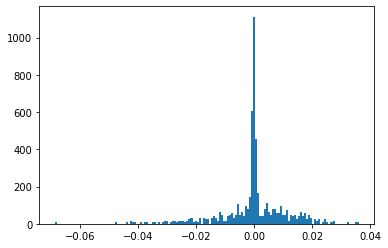

In [ ]:
_ = plt.hist(generated_parameters.numpy().flatten(), 150)

## Encoder Network

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
channel_code_length = 256

In [ ]:
Input = tf.keras.layers.Input(shape=(2 * 8 + channel_code_length))
x = tf.keras.layers.Dense(32, activation="relu")(Input)
x = tf.keras.layers.Dense(2 * 8, activation="relu")(x)

x = tf.keras.layers.Dense(2 * 128)(x)


model = tf.keras.models.Model(Input, x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 272)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                8736      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4352      
Total params: 13,616
Trainable params: 13,616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
channel_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(128 * 8 * 2)),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(channel_code_length, activation=None)
    ], name='channel_model'
)


channel_model.summary()

Model: "channel_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
Total params: 1,180,416
Trainable params: 1,180,416
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_Channels = []
test_Channels = []

for train_channel in train_channels:
    Channel = np.concatenate([np.real(train_channel), np.imag(train_channel)], axis=1).reshape((1, -1))
    train_Channels.append(Channel)

for test_channel in test_channels:
    Channel = np.concatenate([np.real(test_channel), np.imag(test_channel)], axis=1).reshape((1, -1))
    test_Channels.append(Channel)

train_Channels = np.concatenate(train_Channels, axis=0)
test_Channels = np.concatenate(test_Channels, axis=0)

In [ ]:
batch_size = 256

X1 = tf.keras.layers.Input(shape=(2 * 8))
X2 = tf.keras.layers.Input(shape=(128 * 8 * 2))

coded_channel = channel_model(X2)
coded_channel = tf.keras.layers.Lambda(lambda x : tf.tile(x, [batch_size, 1]))(coded_channel)

Sample_with_Channel = tf.keras.layers.Concatenate(axis=-1)([X1, coded_channel])

y = model(Sample_with_Channel)

Final_model = tf.keras.models.Model([X1, X2], y)

Final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
channel_model (Sequential)      (None, 256)          1180416     input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256)          0           channel_model[0][0]              
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
Epochs = 100
batch_size = batch_size
All_Loss = []
loss_tracker = tf.keras.metrics.Mean()
Total_loss_tracker = tf.keras.metrics.Mean()
Total_All_Loss = []


for epoch in range(Epochs):

    X = np.concatenate([np.real(samples), np.imag(samples)], axis=1)

    flag = 0
    pbar = tqdm(train_channels)
    for train_channel in pbar:

        real_y = generate_real_target(samples, train_channel)
        Y = np.concatenate([np.real(real_y), np.imag(real_y)], axis=1)
        Channel = np.concatenate([np.real(train_channel), np.imag(train_channel)], axis=1).reshape((1, -1))

        for counter in range(int(4 ** 8 / batch_size)):
            loss_tracker.reset_states()
            x_batch, y_batch =  X[counter * batch_size:(counter + 1) * batch_size], Y[counter * batch_size:(counter + 1) * batch_size]
            with tf.GradientTape() as tape:
                preds = Final_model([x_batch, Channel])

                loss = loss_fn(y_batch, preds)
                loss_tracker.update_state(loss)
            grads = tape.gradient(loss, Final_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, Final_model.trainable_weights))

        
        Total_loss_tracker.update_state(loss_tracker.result())
        pbar.set_description("Epoch : %d / %d , Training Loss %f , Loss %f" % \
                             (epoch, Epochs, float(Total_loss_tracker.result()), float(loss_tracker.result())))
    pbar.close()

    #buff_loss = loss_tracker.result()
    #Total_loss_tracker.update_state(buff_loss)

    #if epoch % len(Images) == 0:
    #   Total_All_Loss.append(float(Total_loss_tracker.result()))
    #   Total_loss_tracker.reset_states()
    #   
    #   print(20 * "*", f"  {epoch}  ", 20 * "*")
    #   print("Training Loss End of Epoch: %.4f" % (Total_All_Loss[-1],))
    #   print(20 * "*", f"  {epoch}  ", 20 * "*")
       

    #All_Loss.append(float(buff_loss))
    #print("Training Loss End of Epoch: %.4f" % (float(buff_loss),))
    loss_tracker.reset_states()

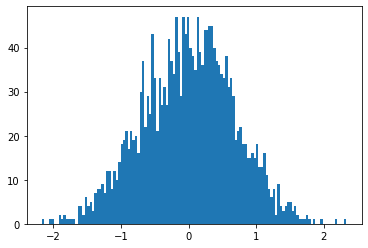

In [ ]:
_ = plt.hist(Channel.flatten(), 128)